## Моделирование последовательных данных с использованием рекуррентных нейронных сетей

Стандартные модели
на основе нейронных сетей, подобные многослойному персептрону (MLP)
и сверточным нейронным сетям (CNN) для данных изображений, делают
допущение о независимости обучающих образцов друг от друга и потому
не содержат в себе информацию упорядочивания. Можно сказать, что модели подобного рода не имеют памяти для ранее встречавшихся обучающих
образцов. Например, образцы проходят через шаги прямого и обратного
распространения, а веса обновляются независимо от порядка, в котором обрабатывались обучающие образцы.
Напротив, сети RNN спроектированы для моделирования последовательностей и способны запоминать прошлую информацию, а также соответствующим образом обрабатывать новые события, что считается очевидным
преимуществом при работе с последовательными данными.

Задачи моделирования последовательностей, зависящие от категории отношений между входными и выходными данными:

<img src='pic/rnncategory.png' width='490'>

- __Многие к одному.__ Входные данные представляют собой последовательность, но выход является вектором фиксированного размера или скаляром, а не последовательностью. В смысловом анализе вход основан на тексте (например, рецензия на фильм) и выходом будет метка класса (например, метка, обозначающая то, понравился ли фильм рецензенту).
- __Один ко многим.__ Входные данные имеют стандартный формат и не являются последовательностью, но выход представляет собой последовательность. Примером такой категории служит подписание изображений - на входе подается изображение, а на выходе получается фраза на английском языке, подводящая итог по содержимому изображения.
- __Многие ко многим.__ Входные и выходные массивы являются последовательностями. Категория "многие ко многим" может дополнительно разделяться на основе того, синхронизированы ли вход и выход. Например, синхронизированная задача моделирования вида "многие ко многим" - классификация видеороликов, когда помечается каждый кадр в видеоролике. Примером отсроченной задачи моделирования категории "многие ко многим" может быть перевод с одного языка на другой (машина должна прочитать и обработать фразу целиком, прежде чем выдать ее перевод).

#### Механизм организации циклов рекуррентной нейронной сети

<img src='pic/rnndnn.png' width='450'>

В стандартной нейронной сети прямого распространения информация
проходит от входа до скрытого слоя и затем от скрытого слоя до выходного
слоя. С другой стороны, в сети RNN скрытый слой получает информацию
от входного слоя текущего временного шага и от скрытого слоя предыдущего временного шага. Поток информации в смежных временных шагах внутри скрытого слоя позволяет сети иметь память о прошедших событиях. Этот цикл называется ***рекуррентное ребро***.

Для представления RNN может быть развернута во времени:

<img src='pic/rnntimed.png' width='450'>

Скрытый слой в сети
RNN принимает два отдельных набора входов - предварительную активацию из входного слоя и активацию этого же скрытого слоя из предыдущего
временного шага t-1.

#### Вычисление активаций в сети RNN

В однослойной сети RNN различают следующие матрицы весов: 
- $W_{xh}$ - матрица весов между входом $W^{(t)}$ и скрытым слоем $h$;
- $W_{hh}$ - матрица весов, ассоциированная с рекуррентным слоем и выходным слоем;
- $W_{h0}$ - матрица весов между скрытым слоем и выходным слоем.

<img src='pic/rnnw.png' width='400'>

В определенных реализациях можно заметить, что матрицы весов $W_{xh}$
и $W_{hh}$ объединены в комбинированную матрицу $W_{h}$ = [$W_{xh}$; $W_{hh}$].

Иллюстрация процесса расчета активаций по двум уравнениям (без объединения матриц и с объединением матриц [$W_{xh}$; $W_{hh}$]):

<img src='pic/rnnact.png' width='500'>

<img src='pic/rnnbackprop.png' width='400'>

#### Виды реккурентности

<img src='pic/rnnclass.png' width='500'>

"Выходной к выходному" в TF (return_sequences=True - возвращение последовательности, False - возвращение последнего выхода последовательности):

In [1]:
import tensorflow as tf

tf.random.set_seed(1)

In [2]:
rnn_layer = tf.keras.layers.SimpleRNN(units=2, use_bias=True,
                                      return_sequences=True)
rnn_layer.build(input_shape=(None, None, 5))

w_xh, w_oo, b_h = rnn_layer.weights
print('shape W_xh:', w_xh.shape)
print('shape W_oo:', w_oo.shape)
print('shape b_h:', b_h.shape)

shape W_xh: (5, 2)
shape W_oo: (2, 2)
shape b_h: (2,)


Форма входа для этого слоя выглядит как (None, None, 5), где первым
измерением является измерение пакета (None означает переменный размер
пакета), второе измерение соответствует последовательности (None означает
переменную длину последовательности) и последнее измерение относится к
признакам.

Прямой проход слоя (вручную расчитываем выходы на каждом временном шаге):

In [3]:
x_seq = tf.convert_to_tensor([[1.0]*5, [2.0]*5, [3.0]*5], dtype=tf.float32)
x_seq

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[1., 1., 1., 1., 1.],
       [2., 2., 2., 2., 2.],
       [3., 3., 3., 3., 3.]], dtype=float32)>

In [4]:
# выход SimpleRNN
output = rnn_layer(tf.reshape(x_seq, shape=(1, 3, 5)))

In [5]:
# ручной расчет выхода
out_man = []
for t in range(len(x_seq)):
    xt = tf.reshape(x_seq[t], (1, 5))
    print(f'Временной шаг => {t}')
    print(f'Выход: {xt.numpy()}')

    ht = tf.matmul(xt, w_xh) + b_h
    print(f'Скрытый слой: {ht.numpy()}')

    if t > 0:
        prev_o = out_man[t-1]
    else:
        prev_o = tf.zeros(shape=(ht.shape))
    ot = ht + tf.matmul(prev_o, w_oo)
    ot = tf.math.tanh(ot)
    out_man.append(ot)
    print(f'Выход вручную: {ot.numpy()}')
    print(f'Выход SimpleRNN: {output[0][t].numpy()}')
    print()

Временной шаг => 0
Выход: [[1. 1. 1. 1. 1.]]
Скрытый слой: [[0.41464037 0.96012145]]
Выход вручную: [[0.39240566 0.74433106]]
Выход SimpleRNN: [0.39240566 0.74433106]

Временной шаг => 1
Выход: [[2. 2. 2. 2. 2.]]
Скрытый слой: [[0.82928073 1.9202429 ]]
Выход вручную: [[0.80116504 0.99129474]]
Выход SimpleRNN: [0.80116504 0.99129474]

Временной шаг => 2
Выход: [[3. 3. 3. 3. 3.]]
Скрытый слой: [[1.2439212 2.8803644]]
Выход вручную: [[0.9546827 0.9993069]]
Выход SimpleRNN: [0.9546827 0.9993069]



#### Сложности изучения долгосрочных взаимодействий
Обратное распространение во времени привносит ряд сложностей. Из-за наличия множителя $${{dh^{(t)}}\over {dh^{(k)}}}$$ в расчете градиентов функции потерь
возникает так называемая проблемы исчезновения (vanishing) и взрывного
роста (exploding) градиентов.

Этот множитель имеет $t-k$ умножений, вследствие чего умножение $t-k$ раз веса $w$ дает множитель $w^{t-k}$. Если $|w|<1$, то множитель $w^{t-k}$ становится очень малым при большом $t-k$. Если вес рекуррентного ребра $|w|>1$, тогда $w^{t-k}$ становится очень большим при большом $t-k$. Следует отметить, что $t-k$ относится к долгосрочным зависимостям.

#### LSTM - ячейки долгой краткосрочной памяти

Строительным блоком элемента LSTM является ячейка памяти, которая по существу представляет или заменяет скрытый слой стандартных сетей RNN. В каждой ячейке памяти имеется рекуррентное ребро с упомянутым ранее желательным весом w = l для преодоления проблем исчезновения и взрывного роста градиентов. Значения, ассоциированные с этим рекуррентным ребром, вместе называются состоянием ячейки.

<img src='pic/ltsm.png' width='500'>

Поток информации в этой ячейке памяти управляется несколькими вычислительными элементами (часто называемыми шлюзами (gate)).
__*__ - поэлементное произведение,
__+__ - поэлементное суммирование.

В ячейке LSTM различают три типа шлюзов:
- Шлюз забывапия (***f***) позволяет ячейке памяти сбрасывать свое состояние, не возрастая до бесконечности. Фактически шлюз забывания решает, какой информации проходить разрешено, а какой запрещено. <img src='pic/gatef.png' width='200'>
- Входной шлюз (***i***) и зиачение-кандидат (***Ĉ***) отвечают за обновление состояния ячейки. <img src='pic/gateic.png' width='200'>
- Выходной шлюз (***o***) решает, как обновлять значения скрытых элементов <img src='pic/gateo.png' width='200'>

#### Прогнозирование отношения в рецензиях на фильмы IMDb

Архитектура RNN - "многие к одному"

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('movie_data.csv', encoding='utf-8')

In [3]:
df.head()

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


Предварительная обработка:
1. Создать объект набора данных TensorFlow и расщепить его на обучающую, испытательную и проверочную части.
2. Идентифицировать уникальные слова в обучающем наборе.
3. Отобразить каждое уникальное слово на уникальное целое число и закодировать текст рецензии с помощью этих целых чисел (индексов уникальных слов).
4. Разделить набор данных на мини-пакеты, которые будут служить входом для модели.

In [4]:
# 1 step
target = df.pop('sentiment')
ds_raw = tf.data.Dataset.from_tensor_slices((df.values, target.values))

In [5]:
for ex in ds_raw.take(3):
    tf.print(ex[0].numpy()[0][:50], ex[1])

b'In 1974, the teenager Martha Moxley (Maggie Grace)' 1
b'OK... so... I really like Kris Kristofferson and h' 0
b'***SPOILER*** Do not read this, if you think about' 0


In [6]:
# train valid test
tf.random.set_seed(1)

ds_raw = ds_raw.shuffle(50000, reshuffle_each_iteration=False)
ds_raw_test = ds_raw.take(25000)
ds_raw_train_valid = ds_raw.skip(25000)
ds_raw_train = ds_raw_train_valid.take(20000)
ds_raw_valid = ds_raw_train_valid.skip(20000)

In [12]:
# 2 step
from collections import Counter

tokenizer = tfds.deprecated.text.Tokenizer()
token_counts = Counter()
for example in ds_raw_train:
    tokens = tokenizer.tokenize(example[0].numpy()[0])
    token_counts.update(tokens)
print('Размер словаря:', len(token_counts))

Размер словаря: 87007


In [13]:
# 3 step
encoder = tfds.deprecated.text.TokenTextEncoder(token_counts)

Один индекс резервируется для неизвестных слов (не из train ds). Ещё один индекс резервируетсядля заполнителя, который регулирует длину последовательности. То есть длина encoder = 87007 + 2

In [14]:
example_str = 'This is an example!'
print(encoder.encode(example_str))

[232, 9, 270, 1123]


In [18]:
# 3-A step
def encode(text_tensor, label):
    text = text_tensor.numpy()[0]
    encoded_text = encoder.encode(text)
    return encoded_text, label


def encode_map_fn(text, label):
    return tf.py_function(encode, inp=[text, label],
                          Tout=(tf.int64, tf.int64))

In [19]:
ds_train = ds_raw_train.map(encode_map_fn)
ds_valid = ds_raw_valid.map(encode_map_fn)
ds_test = ds_raw_test.map(encode_map_fn)

In [20]:
tf.random.set_seed(1)
for example in ds_train.shuffle(1000).take(5):
    print('Длина последовательности:', example[0].shape)

Длина последовательности: (24,)
Длина последовательности: (179,)
Длина последовательности: (262,)
Длина последовательности: (535,)
Длина последовательности: (130,)


В текущий момент последовательности имеют разные длины (как видно в результате
выполнения предыдущего кода для пяти произвольно выбранных образцов).
Хотя в общем случае сети RNN способны обрабатывать последовательности
с разной длиной, нам придется обеспечить одинаковую длину у всех последовательностей в мини-пакете с целью их эффективного хранения в тензоре.

TensorFlow предлагает метод `padded_batch()` (взамен `batch()`),который будет автоматически дополнять следующие друг за другом элементы, объединяемые в пакет, значениями заполнителя (нулями), так что все последовательности внутри пакета будут иметь одну и ту же форму.

In [21]:
# example
ds_subset = ds_train.take(8)
for example in ds_subset:
    print('Размер индивидуального элемента:', example[0].shape)

Размер индивидуального элемента: (119,)
Размер индивидуального элемента: (688,)
Размер индивидуального элемента: (308,)
Размер индивидуального элемента: (204,)
Размер индивидуального элемента: (326,)
Размер индивидуального элемента: (240,)
Размер индивидуального элемента: (127,)
Размер индивидуального элемента: (453,)


In [22]:
# разделение поднабора на пакеты
ds_batched = ds_subset.padded_batch(4, padded_shapes=([-1], []))
for batch in ds_batched:
    print('Размерность пакета:', batch[0].shape)

Размерность пакета: (4, 688)
Размерность пакета: (4, 453)


In [23]:
# 4 step
train_data = ds_train.padded_batch(32, padded_shapes=([-1], []))
valid_data = ds_valid.padded_batch(32, padded_shapes=([-1], []))
test_data = ds_test.padded_batch(32, padded_shapes=([-1], []))

##### Слой Embedding (вложение)

Преобразование целочисленных признаков в One-hot-encoding векторы может страдать от "проклятия размерности" при большом количестве слов.
Слой Embedding позволяет сопоставить каждое слово с вектором фиксированного размера, содержащим вещественные значения (например, в диапазоне [-1, 1]).

<img src='pic/embending.png' width='500'>

Приемущества вложения перед унитарным кодированивем:
- понижение размерности пространства признаков с целью сокращения эффекта "проклятия размерности";
- выделение заметных признаков из-за того, что слой вложения в нейронной сети может оптимизироваться (обучаться).

In [24]:
# example
from tensorflow.keras.layers import Embedding

model = tf.keras.Sequential()
model.add(Embedding(input_dim=100, output_dim=6,
                    input_length=20,
                    name='embed-layer'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed-layer (Embedding)      (None, 20, 6)             600       
Total params: 600
Trainable params: 600
Non-trainable params: 0
_________________________________________________________________


Вход этой модели (слой вложений) обязан иметь ранг 2 с размерностью

`(размер пакета) x (длина входа)`, где длина входа представляет собой длину
последовательностей (установленную здесь в 20 посредством аргумента
`input_length`). Скажем, входной последовательностью в мини-пакете может быть 
`<14,43,52,61,8,19,67,83,1О,7,42,87,56,18,94,17,67,90,6,39>`, каждый
элемент которой является индексом уникального слова. 

Выход будет иметь размерность

`(размер пакета) х (длина входа) х (размерность вложения)`, где
размерность вложения - размер признаков вложения (установленный
здесь в 6 через аргумент `output_dim`). Еще один аргумент, предоставляемый слою вложений, `input_dirm`, соответствует уникальным целочисленным значениям, которые модель будет получать в качестве входа (например,
n + 2, установленное здесь в 100). Таким образом, матрица вложений в нашем случае имеет размер `100 х 6`. 


In [25]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dense

In [26]:
model = Sequential()
model.add(Embedding(input_dim=1000, output_dim=32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          32000     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 36,193
Trainable params: 36,193
Non-trainable params: 0
_________________________________________________________________


Слой Bidirectional заставляет рекуррентные слои проходить по входным данным последовательностям в обоих направлениях - от начала до конца и обратно. Оболочка Bidirectional делает два прохода по каждой входной последовательности: прямой проход и противоположный или обратный проход. Результаты таких прямых
и обратных проходов по умолчанию будут объединяться. Но если
необходимо изменить это поведение, тогда можно установить аргумент `merge_mode` в `'sum'` (сложение), `'mul'` (умножение), `'ave'` (для взятия среднего из двух), `'concat'` (для объединения; стандартное значение) или `'None'` (для возвращения двух тензоров в списке).

In [27]:
embedding_dim = 20
vocab_size = len(token_counts) + 2

tf.random.set_seed(1)

bi_ltsm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size,
                              output_dim=embedding_dim,
                              name='embed-layer'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, name='lstm-layer'),
                                  name='bidir-lstm'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

bi_ltsm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed-layer (Embedding)      (None, None, 20)          1740180   
_________________________________________________________________
bidir-lstm (Bidirectional)   (None, 128)               43520     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,792,021
Trainable params: 1,792,021
Non-trainable params: 0
_________________________________________________________________


In [28]:
bi_ltsm_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'])

history = bi_ltsm_model.fit(train_data,
                            validation_data=valid_data,
                            epochs=10)

Epoch 1/10
625/625 [==============================] - 55s 80ms/step - loss: 0.5119 - accuracy: 0.7310 - val_loss: 0.3569 - val_accuracy: 0.8552
Epoch 2/10
625/625 [==============================] - 49s 79ms/step - loss: 0.2408 - accuracy: 0.9087 - val_loss: 0.3818 - val_accuracy: 0.8564
Epoch 3/10
625/625 [==============================] - 49s 79ms/step - loss: 0.1543 - accuracy: 0.9472 - val_loss: 0.4730 - val_accuracy: 0.8332
Epoch 4/10
625/625 [==============================] - 50s 80ms/step - loss: 0.1037 - accuracy: 0.9656 - val_loss: 0.4992 - val_accuracy: 0.8578
Epoch 5/10
625/625 [==============================] - 49s 79ms/step - loss: 0.0677 - accuracy: 0.9786 - val_loss: 0.5802 - val_accuracy: 0.8314
Epoch 6/10
625/625 [==============================] - 50s 79ms/step - loss: 0.0436 - accuracy: 0.9865 - val_loss: 0.8245 - val_accuracy: 0.8210
Epoch 7/10
625/625 [==============================] - 50s 79ms/step - loss: 0.0386 - accuracy: 0.9889 - val_loss: 0.6365 - val_accuracy:

Text(0, 0.5, 'accuracy')

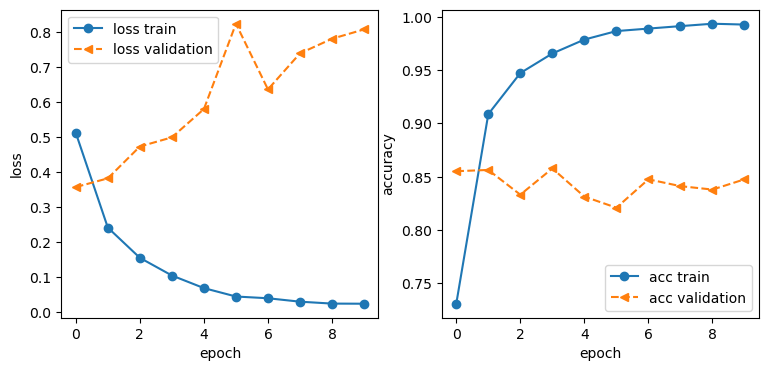

In [29]:
import matplotlib.pyplot as plt

hist = history.history

x = np.arange(len(hist['loss']))

fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].plot(x, hist['loss'], '-o', label='loss train')
ax[0].plot(x, hist['val_loss'], '--<', label='loss validation')
ax[0].legend()
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')

ax[1].plot(x, hist['accuracy'], '-o', label='acc train')
ax[1].plot(x, hist['val_accuracy'], '--<', label='acc validation')
ax[1].legend()
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')

In [30]:
test_results = bi_ltsm_model.evaluate(test_data)
print('test accuracy:', test_results[1])

782/782 [==============================] - 37s 47ms/step - loss: 0.7884 - accuracy: 0.8471
test accuracy: 0.8471199870109558


#### Реализация других слоев для RNNimport pandas as pd

In [1]:
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
from collections import Counter

def preprocess_datasets(ds_raw_train,
                        ds_raw_valid,
                        ds_raw_test,
                        max_seq_length=None,
                        batch_size=32):
    # 2 step
    tokenizer = tfds.deprecated.text.Tokenizer()
    token_counts = Counter()

    for example in ds_raw_train:
        tokens = tokenizer.tokenize(example[0].numpy()[0])
        if max_seq_length is not None:
            tokens = tokens[-max_seq_length:]
        token_counts.update(tokens)

    print('Размер словаря:', len(token_counts))

    # 3 step
    encoder = tfds.deprecated.text.TokenTextEncoder(token_counts)

    def encode(text_tensor, label):
        text = text_tensor.numpy()[0]
        encoded_text = encoder.encode(text)
        if max_seq_length is not None:
            encoded_text = encoded_text[-max_seq_length:]
        return encoded_text, label

    def encode_map_fn(text, label):
        return tf.py_function(encode, inp=[text, label],
                              Tout=(tf.int64, tf.int64))

    ds_train = ds_raw_train.map(encode_map_fn)
    ds_valid = ds_raw_valid.map(encode_map_fn)
    ds_test = ds_raw_test.map(encode_map_fn)

    # step 4
    train_data = ds_train.padded_batch(batch_size, padded_shapes=([-1], []))
    valid_data = ds_valid.padded_batch(batch_size, padded_shapes=([-1], []))
    test_data = ds_test.padded_batch(batch_size, padded_shapes=([-1], []))
    return (train_data, valid_data, test_data, len(token_counts))

In [3]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense

In [19]:
def build_rnn_model(embedding_dim, vocab_size,
                    recurrent_type='SimpleRNN',
                    n_recurrent_units=64,
                    n_recurrent_layers=1,
                    bidirectional=True):
    tf.random.set_seed(1)

    model = tf.keras.Sequential()
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=embedding_dim,
                        name='embed-layer'))
    for i in range(n_recurrent_layers):
        return_sequences = (i < n_recurrent_layers-1)

        if recurrent_type == 'SimpleRNN':
            recurrent_layer = SimpleRNN(units=n_recurrent_units,
                                        return_sequences=return_sequences,
                                        name=f'simprnn-layer-{i}')
        elif recurrent_type == 'LSTM':
            recurrent_layer = LSTM(units=n_recurrent_units,
                                   return_sequences=return_sequences,
                                   name=f'lstm-layer-{i}')
        elif recurrent_type == 'GRU':
            recurrent_layer = GRU(units=n_recurrent_units,
                                  return_sequences=return_sequences,
                                  name=f'gru-layer-{i}')

        if bidirectional:
            recurrent_layer = Bidirectional(recurrent_layer,
                                            name='bidir-'+recurrent_layer.name)
        model.add(recurrent_layer)

    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [14]:
import matplotlib.pyplot as plt
import numpy as np
def plot_loss_acc(hist):
    hist = history.history

    x = np.arange(len(hist['loss']))

    fig, ax = plt.subplots(1, 2, figsize=(9, 4))
    ax[0].plot(x, hist['loss'], '-o', label='loss train')
    ax[0].plot(x, hist['val_loss'], '--<', label='loss validation')
    ax[0].legend()
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')

    ax[1].plot(x, hist['accuracy'], '-o', label='acc train')
    ax[1].plot(x, hist['val_accuracy'], '--<', label='acc validation')
    ax[1].legend()
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('accuracy')
    plt.show()

In [6]:
df = pd.read_csv('movie_data.csv', encoding='utf-8')
target = df.pop('sentiment')
ds_raw = tf.data.Dataset.from_tensor_slices((df.values, target.values))
tf.random.set_seed(1)

ds_raw = ds_raw.shuffle(50000, reshuffle_each_iteration=False)
ds_raw_test = ds_raw.take(25000)
ds_raw_train_valid = ds_raw.skip(25000)
ds_raw_train = ds_raw_train_valid.take(20000)
ds_raw_valid = ds_raw_train_valid.skip(20000)

In [7]:
batch_size = 32
embedding_dim = 20
max_seq_length = 100  # последние 100 лексем

train_data, valid_data, test_data, n = preprocess_datasets(
    ds_raw_train, ds_raw_valid, ds_raw_test,
    max_seq_length=max_seq_length,
    batch_size=batch_size
)

Размер словаря: 58063


In [8]:
vocab_size = n + 2

In [9]:
rnn_model = build_rnn_model(embedding_dim, vocab_size,
                            recurrent_type='SimpleRNN',
                            n_recurrent_units=64,
                            n_recurrent_layers=1,
                            bidirectional=True)

In [10]:
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed-layer (Embedding)      (None, None, 20)          1161300   
_________________________________________________________________
bidir-simprnn-layer-0 (Bidir (None, 128)               10880     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,180,501
Trainable params: 1,180,501
Non-trainable params: 0
_________________________________________________________________


In [11]:
rnn_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])

In [12]:
history = rnn_model.fit(
    train_data,
    validation_data=valid_data,
    epochs=10)

Epoch 1/10
625/625 [==============================] - 221s 350ms/step - loss: 0.6965 - accuracy: 0.5224 - val_loss: 0.6695 - val_accuracy: 0.6002
Epoch 2/10
625/625 [==============================] - 219s 350ms/step - loss: 0.5836 - accuracy: 0.6860 - val_loss: 0.5064 - val_accuracy: 0.7592
Epoch 3/10
625/625 [==============================] - 217s 347ms/step - loss: 0.4746 - accuracy: 0.7776 - val_loss: 0.6283 - val_accuracy: 0.6722
Epoch 4/10
625/625 [==============================] - 217s 347ms/step - loss: 0.3582 - accuracy: 0.8392 - val_loss: 0.7319 - val_accuracy: 0.6712
Epoch 5/10
625/625 [==============================] - 217s 348ms/step - loss: 0.1713 - accuracy: 0.9321 - val_loss: 0.9283 - val_accuracy: 0.6680
Epoch 6/10
625/625 [==============================] - 217s 347ms/step - loss: 0.0867 - accuracy: 0.9677 - val_loss: 1.1623 - val_accuracy: 0.6778
Epoch 7/10
625/625 [==============================] - 217s 348ms/step - loss: 0.0485 - accuracy: 0.9825 - val_loss: 1.6042 -

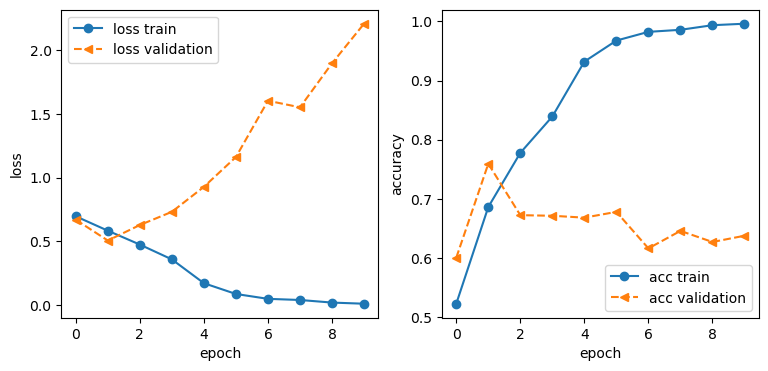

In [15]:
plot_loss_acc(history)

In [17]:
results = rnn_model.evaluate(test_data)
print('test accuracy:', results[1])

782/782 [==============================] - 51s 65ms/step - loss: 2.0946 - accuracy: 0.6480
test accuracy: 0.6480000019073486


In [22]:
batch_size = 32
embedding_dim = 20
max_seq_length = None
train_data, valid_data, test_data, n = preprocess_datasets(
    ds_raw_train, ds_raw_valid, ds_raw_test,
    max_seq_length=max_seq_length,
    batch_size=batch_size
)

Размер словаря: 87007


In [23]:
vocab_size = n + 2

In [24]:
rnn_model = build_rnn_model(embedding_dim, vocab_size,
                            recurrent_type='GRU',
                            n_recurrent_units=64,
                            n_recurrent_layers=2,
                            bidirectional=True)
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed-layer (Embedding)      (None, None, 20)          1740180   
_________________________________________________________________
bidir-gru-layer-0 (Bidirecti (None, None, 128)         33024     
_________________________________________________________________
bidir-gru-layer-1 (Bidirecti (None, 128)               74496     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 1,856,021
Trainable params: 1,856,021
Non-trainable params: 0
_________________________________________________________________


In [25]:
rnn_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])

In [26]:
history = rnn_model.fit(
    train_data,
    validation_data=valid_data,
    epochs=10)

Epoch 1/10
625/625 [==============================] - 81s 120ms/step - loss: 0.5600 - accuracy: 0.6933 - val_loss: 0.3954 - val_accuracy: 0.8260
Epoch 2/10
625/625 [==============================] - 74s 118ms/step - loss: 0.2433 - accuracy: 0.9033 - val_loss: 0.3315 - val_accuracy: 0.8814
Epoch 3/10
625/625 [==============================] - 74s 119ms/step - loss: 0.1061 - accuracy: 0.9619 - val_loss: 0.4053 - val_accuracy: 0.8710
Epoch 4/10
625/625 [==============================] - 75s 119ms/step - loss: 0.0715 - accuracy: 0.9747 - val_loss: 0.4571 - val_accuracy: 0.8664
Epoch 5/10
625/625 [==============================] - 74s 119ms/step - loss: 0.0542 - accuracy: 0.9815 - val_loss: 0.4603 - val_accuracy: 0.8766
Epoch 6/10
625/625 [==============================] - 74s 119ms/step - loss: 0.0354 - accuracy: 0.9878 - val_loss: 0.5125 - val_accuracy: 0.8718
Epoch 7/10
625/625 [==============================] - 78s 125ms/step - loss: 0.0122 - accuracy: 0.9958 - val_loss: 0.7079 - val_ac

In [27]:
results = rnn_model.evaluate(test_data)
print('test accuracy:', results[1])

782/782 [==============================] - 54s 68ms/step - loss: 0.6513 - accuracy: 0.8717
test accuracy: 0.8716800212860107


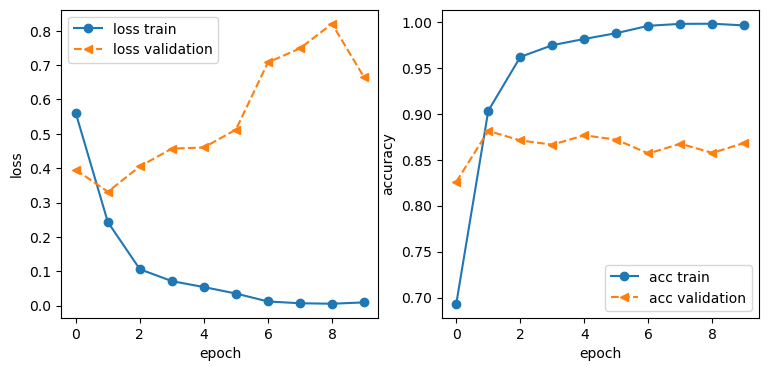

In [28]:
plot_loss_acc(history)

In [ ]:
703